### Insurance charges prediction
Predict the premium that may be charged to policy holder based on his basic health insurance data.
In this notebook we will be covering the following things:
- EDA
- Scaling Numeric Features
- Developing a Data Preprocessing Pipeline
- Fitting `RandomForestRegressor` and `XGBRegressor` models
- Correlation analysins and  analysing feature importance
- Hyperparameter tuning with `GridSearchCV` and `scikit-optimize` library
- Regression model evaluation
- Finding the Optimal Hyperparameters and Training the Model
- Save, load and infer with the best model
- Use weights and bias to optimize hyperparameter

In [1]:
! pip install scikit-learn
! pip install scikit-optimize
! pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


In [3]:
!gdown 1IQHHyvkwqGiJc3BXVrQyk5lr6cLcpXjK

Downloading...
From: https://drive.google.com/uc?id=1IQHHyvkwqGiJc3BXVrQyk5lr6cLcpXjK
To: /content/medical_insurance(1).csv
100% 115k/115k [00:00<00:00, 104MB/s]


In [4]:
df = pd.read_csv('/content/medical_insurance(1).csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.shape

(2772, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [7]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
categorical_features = make_column_selector(dtype_include='O')(df)
numerical_features = make_column_selector(dtype_exclude='O')(df)

print('Categorical feattures: ', categorical_features)
print('Numerical features: ', numerical_features)

Categorical feattures:  ['sex', 'smoker', 'region']
Numerical features:  ['age', 'bmi', 'children', 'charges']


In [9]:
categorical_features, numerical_features

(['sex', 'smoker', 'region'], ['age', 'bmi', 'children', 'charges'])

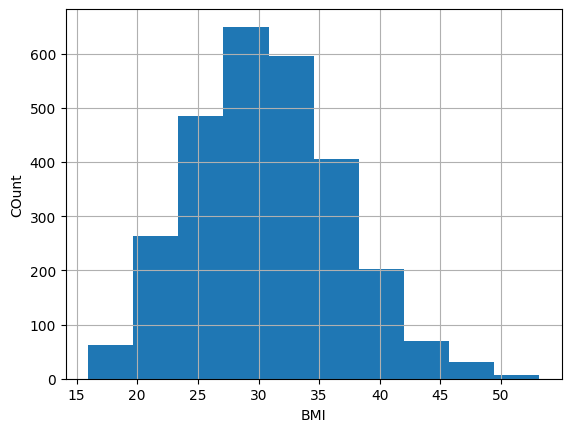

In [10]:
# plt.title('')
df['bmi'].hist()
plt.xlabel('BMI')
plt.ylabel('COunt')
plt.show()

**Centers for Disease Control and Prevention (CDC)** has categories BMI into several categories based on some cut-off points.
- Underweight: less than or equal to 18.4 kg/m2
- Normal weight: 18.5 to 24.9 kg/m2
- Overweight: 25.0 to 39.9 kg/m2
- Obese: ≥40.0 kg/m2

Let's create a new feature BMI category based on the above stat from CDC.

In [11]:
df['bmi_category'] = pd.cut(df['bmi'],
                            bins=[0, 18.4, 24.9, 39.9, 1000],
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

In [12]:
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_category
0,19,female,27.900,0,yes,southwest,16884.92400,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,Overweight
2,28,male,33.000,3,no,southeast,4449.46200,Overweight
3,33,male,22.705,0,no,northwest,21984.47061,Normal
4,32,male,28.880,0,no,northwest,3866.85520,Overweight


In [13]:
def percentage_count(data=None, columns=None, sort=True):
    value_count = df[columns].value_counts(sort=sort)
    df_percentage = pd.DataFrame({'count': value_count,
                                  'percentage': round(value_count/df.shape[0]*100, 2)
                                  })
    return df_percentage


In [14]:
percentage_count(data=df, columns='bmi_category')

,count,percentage
bmi_category,,
Overweight,2068,74.60
Normal,466,16.81
Obese,198,7.14
Underweight,40,1.44


Out of 2772 data samples, 74.6% of people are overweighted and only 1.44% are underweighted.

In [15]:
# charges stats based on bmi category
df.groupby(['bmi_category'])['charges'].agg(['mean', 'median', 'min', 'max']).round(2)

,mean,median,min,max
bmi_category,,,,
Underweight,8852.20,6759.26,1621.34,32734.19
Normal,10187.63,8539.67,1121.87,35069.37
Overweight,13701.34,9487.64,1131.51,62592.87
Obese,16790.98,9748.91,1146.80,63770.43



- Above stats indicates that insurance policyholders classified as "Obese" generally exhibit higher charges, whereas those classified as "Underweight" tend to have lower median charges compared to other categories.

- Interestingly, the minimum values for participants classified as "Underweight" are higher than those for other categories. This warrants further investigation to ascertain whether these higher values are attributable to smoking status or other influencing factors.

In [16]:
# charges stats based on bmi category
df.groupby(['smoker'])['charges'].agg(['mean', 'median', 'min', 'max']).round(2)

,mean,median,min,max
smoker,,,,
no,8417.87,7341.42,1121.87,36910.61
yes,32223.14,34725.88,12829.46,63770.43


The charge for smokers is approximately 37 times higher than that of non-smokers, suggesting that this information could significantly improve model fitting

In [18]:
df.groupby(['region'])['charges'].agg(['mean', 'median', 'min', 'max']).round(2)

,mean,median,min,max
region,,,,
northeast,13475.87,10072.06,1694.80,58571.07
northwest,12463.13,9081.15,1621.34,60021.40
southeast,14748.78,9140.95,1121.87,63770.43
southwest,12164.20,8790.53,1241.56,52590.83


In [19]:
df.groupby(['sex'])['charges'].agg(['mean', 'median', 'min', 'max']).round(2)

,mean,median,min,max
sex,,,,
female,12486.83,9283.56,1607.51,63770.43
male,14013.87,9361.33,1121.87,62592.87


Above stats indicate that males generally exhibit higher charges compared to females. However, upon closer examination of the minimum and maximum values, females appear to have higher charges, with the minimum charge for females being approximately 5k higher than that of males. It's possible that the mean and median statistics for males could be influenced by an imbalance in the dataset between male and female counts. Therefore, let's investigate this potential imbalance first

In [20]:
df['sex'].value_counts()

sex
male      1406
female    1366
Name: count, dtype: int64

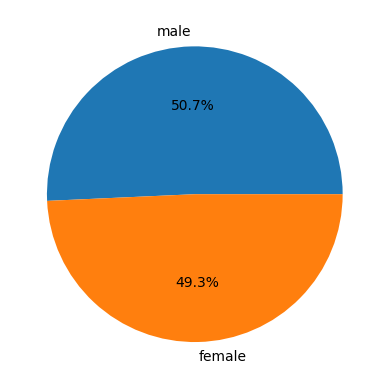

In [21]:
labels = df['sex'].value_counts().index
count = df['sex'].value_counts().values
plt.pie(x=count, labels=labels, autopct='%1.1f%%');

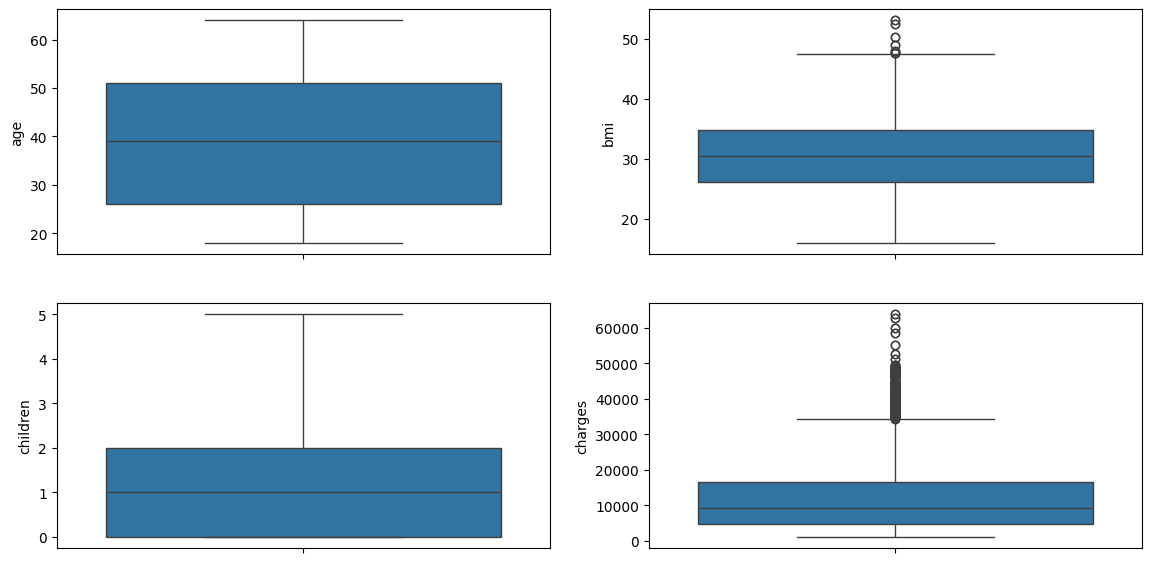

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
axs = axes.flatten()

# Iterate over rows
for fea, ax in zip(numerical_features, axs):
    sns.boxplot(data=df[fea], ax=ax)

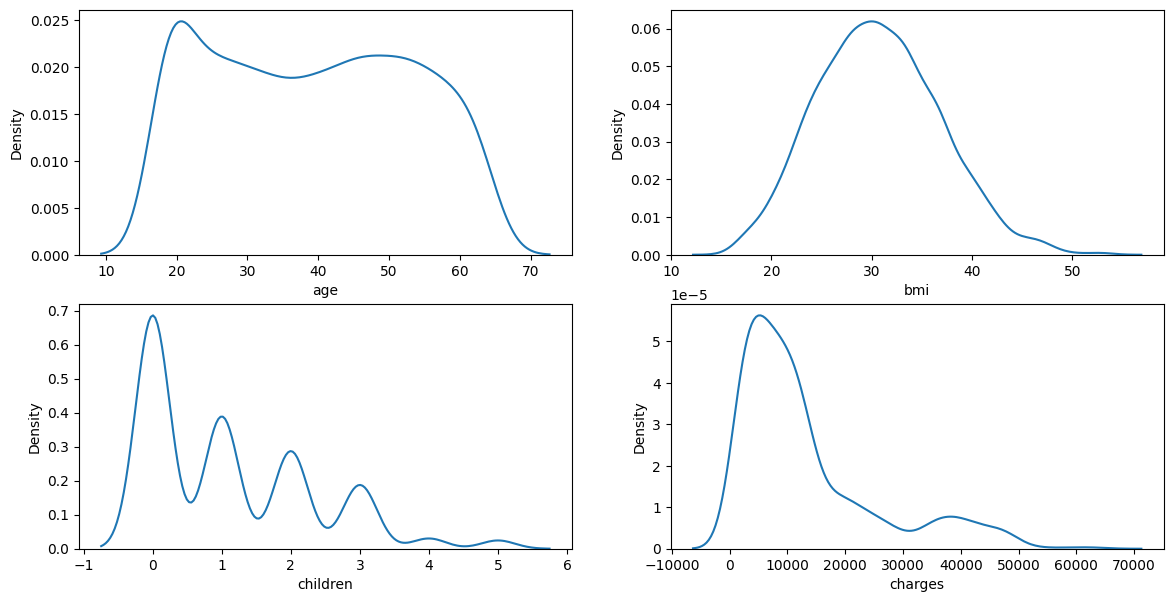

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
axs = axes.flatten()

# Iterate over rows
for fea, ax in zip(numerical_features, axs):
    sns.kdeplot(data=df[fea], ax=ax)

#### Fitting model

In [24]:
X= df.drop(['charges','bmi_category', 'region'],axis=1)
y= df['charges']

In [25]:
# ensure that the splitting of the data preserves the proportion of classes or groups present in a categorical variable
#stratify le train test ma equal ratio ma data divide garcha
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X[['smoker']])

In [26]:
X_train['sex'].unique()

array(['male', 'female'], dtype=object)

In [27]:
categorical_features

['sex', 'smoker', 'region']

In [28]:
ordinal_encoder = OrdinalEncoder()
# nominal_encoder = OneHotEncoder(handle_unknown="ignore")

scaler = MinMaxScaler()

In [29]:
categorical_features[:-1]

['sex', 'smoker']

In [30]:
preprocessor = ColumnTransformer(
    [
        ('ordinal-encoder', ordinal_encoder, categorical_features[:-1]),
        # ('nominal_encoder', nominal_encoder, categorical_features[-1:]),
        ('minmax-scaler', scaler, numerical_features[:-1])
    ],
    remainder='passthrough',    #columns that were not specified in transformers, but present in the data passed to fit will be automatically passed through.
    verbose=True
    )

In [31]:
preprocessor.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal-encoder', OrdinalEncoder(),
                                 ['sex', 'smoker']),
                                ('minmax-scaler', MinMaxScaler(),
                                 ['age', 'bmi', 'children'])],
                  verbose=True)>

In [33]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal-encoder', OrdinalEncoder(),
                                 ['sex', 'smoker']),
                                ('minmax-scaler', MinMaxScaler(),
                                 ['age', 'bmi', 'children'])],
                  verbose=True)

In [34]:
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc= preprocessor.transform(X_test)

[ColumnTransformer]  (1 of 2) Processing ordinal-encoder, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing minmax-scaler, total=   0.0s


In [35]:
X_train_enc.shape, X_test_enc.shape

((2217, 5), (555, 5))

In [36]:
y_train.shape, y_test.shape

((2217,), (555,))

In [37]:
numerical_features

['age', 'bmi', 'children', 'charges']

In [38]:
features = categorical_features[:-1] + numerical_features[:-1]

X_train_new = pd.DataFrame(X_train_enc,columns=features)
X_test_new = pd.DataFrame(X_test_enc,columns=features)

In [39]:
X_train_new.reset_index(drop=True, inplace=True)
X_test_new.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [40]:
data_train = pd.concat([X_train_new, y_train], axis=1)
data_train.tail()

,sex,smoker,age,bmi,children,charges
2212,1.0,1.0,0.695652,0.439602,0.2,41919.09700
2213,1.0,1.0,0.260870,0.520312,0.0,36837.46700
2214,1.0,0.0,0.978261,0.641377,0.6,15170.06900
2215,1.0,0.0,0.804348,0.518832,0.2,11394.06555
2216,1.0,1.0,0.978261,0.514662,0.0,47055.53210


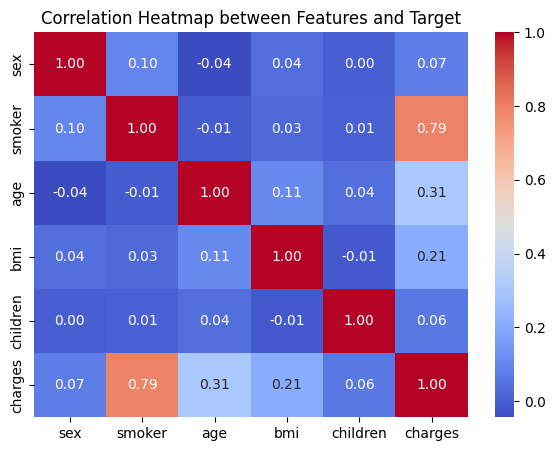

In [42]:
plt.figure(figsize=(7, 5))
sns.heatmap(data_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Features and Target')
plt.show()

The target is found to be highly correlated with features: smoker, age and bmi.

Model Fit

In [43]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from time import time

In [44]:
model_rf_1= RandomForestRegressor(criterion='absolute_error', max_depth=5,
                                  n_estimators=190, random_state=42)

model_rf_1.fit(X_train_new, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=5, n_estimators=190,
                      random_state=42)

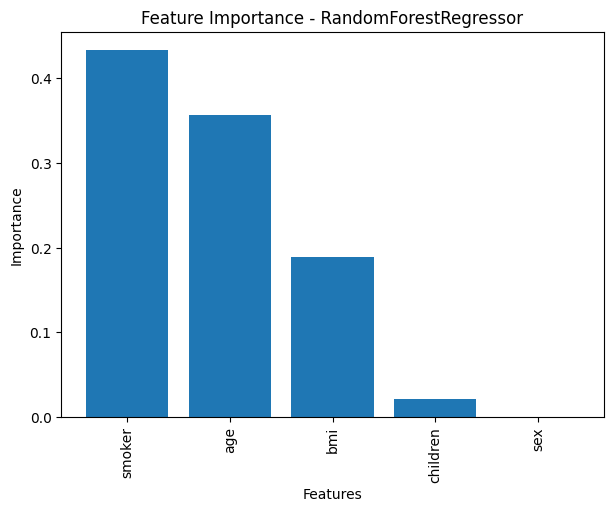

In [46]:
fea_imp = model_rf_1.feature_importances_
fea_name = model_rf_1.feature_names_in_

# Sort feature importances in descending order
indices = fea_imp.argsort()[::-1]

# Plot
plt.figure(figsize=(7,5))
plt.title("Feature Importance - RandomForestRegressor")
plt.bar(range(len(fea_name)), fea_imp[indices], align="center")
plt.xticks(range(len(fea_name)), [fea_name[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

The heatmap displayed earlier indicated that the feature `children` had the lowest correlation of `0.06` with the target variable. However, after fitting the RandomForest model and plotting the feature importance, it revealed that the `children` column holds higher significance than `sex`, contrary to the correlation analysis which previously ranked `sex` as having the second lowest correlation.








We will be calculating all the metrics that are available for regression model analysis in Sklear, prioritizing them based on the dataset's nature.


-`RMSE (Root Mean Squared Error)`: RMSE is suitable when larger errors need heavier penalization. It quantifies the average error magnitude in the same units as the target variable. It's sensitive to outliers.

- `MAE (Mean Absolute Error)`: MAE is ideal for easy interpretation and is less affected by outliers. It measures the average magnitude of errors.

- `MAPE (Mean Absolute Percentage Error)`: MAPE is beneficial for understanding prediction accuracy relative to actual values in percentage terms. It's useful for forecasting tasks, especially with data having varied scales.

- `R-squared (Coefficient of Determination)`: R-squared assesses model fit to the data, indicating the proportion of variance in the dependent variable explained by independent variables. It's commonly used to compare models or overall performance assessment.

In [47]:
class ModelEvaluator:
    def __init__(self, train_actual=None, train_predicted=None, test_actual=None, test_predicted=None):
        # Initialize the ModelEvaluator with actual and predicted values for both training and testing datasets
        self.train_actual = train_actual
        self.train_predicted = train_predicted
        self.test_actual = test_actual
        self.test_predicted = test_predicted

    def calculate_metrics(self, y_true, y_pred):
        # Calculate various evaluation metrics for a given set of true and predicted values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        metrics = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'R-squared': r2.round(2)
        }

        return metrics

    def evaluate(self):
        metrics = {}

        if self.train_actual is not None and self.train_predicted is not None:
            # Calculate and store evaluation metrics for the training dataset
            train_metrics = self.calculate_metrics(self.train_actual, self.train_predicted)
            metrics['Train'] = train_metrics

        if self.test_actual is not None and self.test_predicted is not None:
            # Calculate and store evaluation metrics for the testing dataset
            test_metrics = self.calculate_metrics(self.test_actual, self.test_predicted)
            metrics['Test'] = test_metrics

        # Return the evaluation metrics in a DataFrame
        return pd.DataFrame(metrics)

In [48]:
y_train_pred= model_rf_1.predict(X_train_new)
y_test_pred= model_rf_1.predict(X_test_new)

In [49]:
evaluator_both_pfi = ModelEvaluator(train_actual=y_train, train_predicted= y_train_pred,
                                 test_actual=y_test, test_predicted=y_test_pred)

evaluator_both_pfi.evaluate().round(3)

,Train,Test
MAE,1704.951,1757.019
RMSE,4472.264,4602.963
MAPE,0.124,0.117
R-squared,0.870,0.850


In [50]:
! pip install xgboost

In [51]:
import xgboost as xgb

In [52]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.6,
                              n_estimators=200,random_state=42)

# Configure the EarlyStopping
early_stopping = xgb.callback.EarlyStopping(
    rounds=5,# Number of rounds (iterations) with no improvement after which training will be stopped
    metric_name='rmse', # Metric to be monitored for early stopping (in this case, rmse)
    save_best=True,  # Whether to save the best model during training
)

# Train the model with the EarlyStopping callback
evals = [(X_train_new, y_train),
            (X_test_new, y_test)]

evals_result = {}
xgb_reg.fit(X_train_new, y_train,
            eval_metric=["rmse"], eval_set=evals,
            callbacks=[early_stopping],
            verbose=True)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:6227.72753	validation_1-rmse:6409.02293
[1]	validation_0-rmse:4369.01266	validation_1-rmse:4739.26585
[2]	validation_0-rmse:3777.85914	validation_1-rmse:4255.93045
[3]	validation_0-rmse:3532.69871	validation_1-rmse:4055.78055
[4]	validation_0-rmse:3335.86567	validation_1-rmse:3994.01123
[5]	validation_0-rmse:3255.21892	validation_1-rmse:3924.35112
[6]	validation_0-rmse:3157.74581	validation_1-rmse:3891.10695
[7]	validation_0-rmse:3082.94004	validation_1-rmse:3844.35158
[8]	validation_0-rmse:3004.82652	validation_1-rmse:3800.01513
[9]	validation_0-rmse:2884.36818	validation_1-rmse:3763.83918
[10]	validation_0-rmse:2733.05366	validation_1-rmse:3738.34562
[11]	validation_0-rmse:2676.67934	validation_1-rmse:3720.73532
[12]	validation_0-rmse:2604.61431	validation_1-rmse:3708.28400
[13]	validation_0-rmse:2491.92938	validation_1-rmse:3596.94930
[14]	validation_0-rmse:2381.66355	validation_1-rmse:3513.45541
[15]	validation_0-rmse:2278.19676	validation_1-rmse:3427.73802
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.6, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


- n_estimators:
  - This parameter determines the number of boosting rounds or trees that will be built during the training process. Each boosting round adds a new tree to the ensemble. In the provided code, setting `n_estimators=300` means that the XGBoost model will be trained with 300 boosting rounds.

- objective='reg:squarederror':
  - This parameter specifies that the objective of the XGBoost model is to minimize the squared error, which is suitable for regression tasks. The model aims to make predictions that are as close as possible to the actual target values.

- early_stopping:
  - The EarlyStopping callback is configured to monitor the root mean squared error ('rmse') on the specified evaluation sets (training and testing sets). If there is no improvement in the specified number of rounds (rounds=2), the training process will be stopped early, preventing overfitting.


NOTE:: Early stopping is not available in all scikit-learn models. It's commonly used in iterative optimization algorithms like XGBoost, LightGBM, and CatBoost.

In [53]:
evals_result = xgb_reg.evals_result()

Best iteration: 121


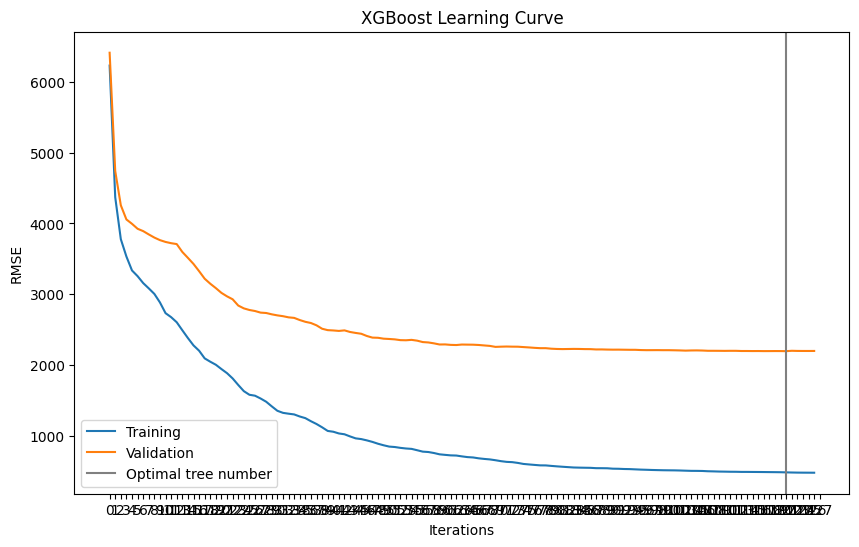

In [54]:
# Plot the learning curve
train_rmse = evals_result['validation_0']['rmse']
valid_rmse = evals_result['validation_1']['rmse']

epochs = len(evals_result['validation_0']['rmse'])
x_axis = range(0, epochs)
best_iter_xgb= xgb_reg.best_iteration
print(f'Best iteration:',best_iter_xgb)

plt.figure(figsize=(10, 6))
plt.plot(x_axis,train_rmse, label='Training')
plt.plot(x_axis,valid_rmse, label='Validation')
plt.axvline(best_iter_xgb, color="gray", label="Optimal tree number")

# Set custom x-axis ticks
plt.xticks(range(0, epochs + 1))

plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.show()

Obtained best model at 187 iteration

### HyperParameter Tuning

`GridSearchCV` exhaustively searches through all possible hyperparameter combinations, while `RandomizedSearchCV` randomly samples a subset of combinations. `.` guarantees finding the optimal combination but can be computationally expensive, while `RandomizedSearchCV` is more efficient but may not guarantee the best combination. The choice between the two depends on factors like the size of the search space, computational resources, and time constraints

###Types of Hyperparameters in XGBoost

In XGBoost, there are two main types of hyperparameters: tree-specific and learning task-specific.
Tree-specific hyperparameters control the construction and complexity of the decision trees:

    max_depth: maximum depth of a tree. Deeper trees can capture more complex patterns in the data, but may also lead to overfitting.
    
    min_child_weight: minimum sum of instance weight (hessian) needed in a child. This can be used to control the complexity of the decision tree by preventing the creation of too small leaves.
    
    subsample: percentage of rows used for each tree construction. Lowering this value can prevent overfitting by training on a smaller subset of the data.
    
    colsample_bytree: percentage of columns used for each tree construction. Lowering this value can prevent overfitting by training on a subset of the features.

Learning task-specific hyperparameters control the overall behavior of the model and the learning process:

    eta (also known as learning rate): step size shrinkage used in updates to prevent overfitting. Lower values make the model more robust by taking smaller steps.
    
    gamma: minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values increase the regularization.
    
    lambda: L2 regularization term on weights. Higher values increase the regularization.
    
    alpha: L1 regularization term on weights. Higher values increase the regularization.

In [55]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

In [56]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'n_estimators': range(14,18),
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
}

In [57]:
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error',return_train_score=True, n_jobs=-1)
# Perform grid searc
grid_search.fit(X_train_new, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.6, ma...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=200,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': range(14, 18),
                         'subsample': [0.8, 0.9]},
             return_train_score=True, scoring='neg_mean_absolute_error')


Negative values are monitored because Scikit-learn follows the convention of maximizing scoring metrics, so it negates metrics like mean squared error (MSE) to adhere to this convention.

In [58]:
grid_search

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.6, ma...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=200,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': range(14, 18),
                         'subsample': [0.8, 0.9]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [59]:
hyperparam_xgboost = pd.DataFrame(grid_search.cv_results_)
# Sort the results by mean test score in descending order and select specific columns
hyperparam_xgboost.sort_values('mean_test_score', ascending=False)[
    ['params', 'mean_test_score', 'mean_train_score',
     'std_test_score', 'std_train_score','mean_score_time', 'rank_test_score']].head(5)

,params,mean_test_score,mean_train_score,std_test_score,std_train_score,mean_score_time,rank_test_score
55,"{'colsample_bytree': 0.8, 'max_depth': 7, 'min...",-2042.931422,-927.490498,68.958929,49.523944,0.004845,1
127,"{'colsample_bytree': 0.9, 'max_depth': 7, 'min...",-2042.931422,-927.490498,68.958929,49.523944,0.009776,1
125,"{'colsample_bytree': 0.9, 'max_depth': 7, 'min...",-2048.687052,-960.970178,74.553487,54.696201,0.004859,3
53,"{'colsample_bytree': 0.8, 'max_depth': 7, 'min...",-2048.687052,-960.970178,74.553487,54.696201,0.004682,3
123,"{'colsample_bytree': 0.9, 'max_depth': 7, 'min...",-2071.083600,-1005.170717,93.414261,42.620943,0.004963,5


In [60]:
# Print the best parameters found
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'colsample_bytree': 0.8, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 17, 'subsample': 0.9}
Best score: -2042.9314224106492


In [61]:
# Get the best model
best_xgb_reg = grid_search.best_estimator_
# best_xgb_reg.fit(X_train_new, y_train)

y_train_pred= best_xgb_reg.predict(X_train_new)
y_test_pred= best_xgb_reg.predict(X_test_new)

evaluator_best_model = ModelEvaluator(train_actual=y_train, train_predicted= y_train_pred,
                                 test_actual=y_test, test_predicted=y_test_pred)

evaluator_best_model.evaluate().round(3)

,Train,Test
MAE,996.489,1751.646
RMSE,1754.959,3193.706
MAPE,0.134,0.213
R-squared,0.980,0.930


The above experiment shows the metrics from RandomForestRegressor is better than XGBRegressor even when the XGBRegressor is fitted with the best hyperparameter.

#### Save and Load the best model

In [62]:
import pickle

In [63]:
# Save the model to a file
with open('xgb_best_model.pkl', 'wb') as file:
    pickle.dump(best_xgb_reg, file)

In [64]:
# Load the model from the file
with open('xgb_best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [65]:
from skopt.space import Integer, Categorical

Let's perform a hyperparmeter search for RandomForest using Bayesian optimization algorithm. Baye's search uses stepwise Bayesian Optimization to explore the most promising hyperparameters in the problem-space.

In [66]:
# constructiing predictyive model pipeline
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal-encoder', OrdinalEncoder(),
                                 ['sex', 'smoker']),
                                ('minmax-scaler', MinMaxScaler(),
                                 ['age', 'bmi', 'children'])],
                  verbose=True)

In [67]:
preprocessor = ColumnTransformer(
    [
        ('ordinal-encoder', ordinal_encoder, categorical_features[:-1]),
        # ('nominal_encoder', nominal_encoder, categorical_features[-1:]),
        ('minmax-scaler', scaler, numerical_features[:-1])
    ],
    remainder='passthrough',    #columns that were not specified in transformers, but present in the data passed to fit will be automatically passed through.
    verbose=False
    )

In [68]:
numerical_pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])
# Combine numerical and categorical pipelines using ColumnTransformer
preproc_pipeline = ColumnTransformer(
    transformers=[
        ('num_pipeline', numerical_pipeline, numerical_features[:-1]),
        ('cat_pipeline', ordinal_encoder, categorical_features[:-1]),
    ],
    remainder='passthrough',
    verbose=False
)

# Define the Regression Model
regression = RandomForestRegressor(random_state=1)

# Create the final pipeline with preprocessing and classifier
pipeline = Pipeline([
    ('preprocessor', preproc_pipeline),
    ('regression', regression)
])


In [69]:
scaler

MinMaxScaler()

In [70]:
# Define the parameters for Bayesian optimization
parameters = {
    'preprocessor__num_pipeline__scaler':[StandardScaler(), MinMaxScaler(), RobustScaler()],
    'regression__criterion': ['squared_error', 'absolute_error'],
    'regression__n_estimators': Integer(170, 300),
    'regression__max_depth': Integer(5,10),
    'regression__min_samples_split': Integer(2,5),
    'regression__max_features': Categorical(['sqrt', 'log2', None])
}

In [71]:
rf_bayesian_search = BayesSearchCV(
        pipeline,
        search_spaces=parameters,
        n_iter=30,  # Adjust the number of iterations as needed
        cv=5,
        scoring='neg_mean_absolute_percentage_error',
        return_train_score=True,
        n_jobs=-1,  # Use -1 to use all available CPU cores
        verbose=0,
        random_state=1,

    )


rf_bayesian_search.fit(X_train_new, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('num_pipeline',
                                                                          Pipeline(steps=[('scaler',
                                                                                           MinMaxScaler())]),
                                                                          ['age',
                                                                           'bmi',
                                                                           'children']),
                                                                         ('cat_pipeline',
                                                                          OrdinalEncoder(),
                                                                          ['sex',
                                                                           'smoker'])])),
                                        ('regression',
                                         RandomForestRegressor(random_state=1))]),
              n_iter=30, n_jobs=-1, random_state=1, ret...
                             'regression__max_depth': Integer(low=5, high=10, prior='uniform', transform='normalize'),
                             'regression__max_features': Categorical(categories=('sqrt', 'log2', None), prior=None),
                             'regression__min_samples_split': Integer(low=2, high=5, prior='uniform', transform='normalize'),
                             'regression__n_estimators': Integer(low=170, high=300, prior='uniform', transform='normalize')})

In [72]:
# Get the best parameters and model
rf_best_params = rf_bayesian_search.best_params_
rf_best_model = rf_bayesian_search.best_estimator_

# Print or use the best parameters and model as needed
print("Best Parameters:", rf_best_params, end='\n\n')
print("Best Model:", rf_best_model)

Best Parameters: OrderedDict([('preprocessor__num_pipeline__scaler', StandardScaler()), ('regression__criterion', 'absolute_error'), ('regression__max_depth', 5), ('regression__max_features', None), ('regression__min_samples_split', 2), ('regression__n_estimators', 272)])

Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat_pipeline',
                                                  OrdinalEncoder(),
                                                  ['sex', 'smoker'])])),
                ('regression',
                 RandomForestRegressor(criterion='absolute_error', max_de

In [73]:
# Create a DataFrame to store the hyperparameter tuning results
hyperparam_rf = pd.DataFrame(rf_bayesian_search.cv_results_)

# Sort the results by mean test score in descending order and select specific columns
hyperparam_rf.sort_values('mean_test_score', ascending=False)[
    ['params', 'mean_test_score', 'mean_train_score',
     'std_test_score', 'std_train_score','mean_score_time', 'rank_test_score']].head(5)

,params,mean_test_score,mean_train_score,std_test_score,std_train_score,mean_score_time,rank_test_score
29,{'preprocessor__num_pipeline__scaler': Standar...,-0.130733,-0.123597,0.007789,0.003265,0.038347,1
19,{'preprocessor__num_pipeline__scaler': MinMaxS...,-0.130805,-0.123510,0.007724,0.003244,0.041470,2
25,{'preprocessor__num_pipeline__scaler': MinMaxS...,-0.130870,-0.123643,0.007508,0.003452,0.023987,3
16,{'preprocessor__num_pipeline__scaler': RobustS...,-0.131955,-0.114058,0.005930,0.003300,0.032965,4
13,{'preprocessor__num_pipeline__scaler': MinMaxS...,-0.138361,-0.107759,0.007256,0.003765,0.052562,5


In [74]:
print('Total iterations:', hyperparam_rf.shape[0])

Total iterations: 30


In [75]:
best_estimator_rf = rf_bayesian_search.best_estimator_
best_estimator_rf.fit(X_train_new, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat_pipeline',
                                                  OrdinalEncoder(),
                                                  ['sex', 'smoker'])])),
                ('regression',
                 RandomForestRegressor(criterion='absolute_error', max_depth=5,
                                       max_features=None, n_estimators=272,
                                       random_state=1))])

In [76]:
y_train_pred= best_estimator_rf.predict(X_train_new)
y_test_pred= best_estimator_rf.predict(X_test_new)

In [77]:
evaluator_best_model = ModelEvaluator(train_actual=y_train, train_predicted= y_train_pred,
                                 test_actual=y_test, test_predicted=y_test_pred)

evaluator_best_model.evaluate().round(3)

,Train,Test
MAE,1704.822,1755.793
RMSE,4474.493,4607.164
MAPE,0.125,0.117
R-squared,0.870,0.850


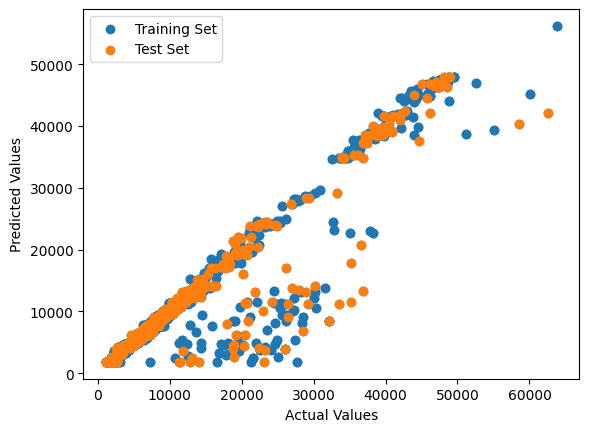

In [78]:
plt.scatter(y_train, y_train_pred, label='Training Set')
plt.scatter(y_test, y_test_pred, label='Test Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [79]:
# Save the model to a file
with open('rf_best_model.pkl', 'wb') as file:
    pickle.dump(best_estimator_rf, file)
# Load the model from the file
with open('rf_best_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [80]:
# made prediction with loaded model
loaded_model.predict(X_test_new.tail(5))

array([16956.15597426,  7012.49494688,  3066.57275983,  7019.95405   ,
        4176.04606866])

Using weights and biases

In [81]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.5/289.5 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00


In [82]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [83]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "accuracy",
      "goal": "maximize"
    },
    "parameters": {
        "booster": {
            "values": ["gbtree","gblinear"]
        },
        "max_depth": {
            "values": [3, 6, 9, 12]
        },
        "learning_rate": {
            "values": [0.1, 0.05, 0.2]
        },
        "subsample": {
            "values": [1, 0.5, 0.3]
        }
    }
}

In [ ]:
# parameters_dict.update({
#     'subsample': {
#         'value': [1, 0.6, 0.4, 0.2]}
#     })

In [84]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'accuracy'},
 'parameters': {'booster': {'values': ['gbtree', 'gblinear']},
                'learning_rate': {'values': [0.1, 0.05, 0.2]},
                'max_depth': {'values': [3, 6, 9, 12]},
                'subsample': {'values': [1, 0.5, 0.3]}}}


initialize sweep

In [85]:
sweep_id = wandb.sweep(sweep_config, project="XGBoost-tuning-demo")

Create sweep with ID: zkx0yof5
Sweep URL: https://wandb.ai/ioe-tu-edu-np-/XGBoost-tuning-demo/sweeps/zkx0yof5


wandb.init() – Initialize a new W&B Run. Each Run is a single execution of the training function.

wandb.config – Save all your hyperparameters in a configuration object so they can be logged. Read more about how to use wandb.config here.

wandb.log() – log model behavior to W&B. Here, we just log the performance; see this Colab for all the other rich media that can be logged with wandb.log

In [86]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv

--2024-06-07 12:50:56--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23278 (23K) [text/plain]
Saving to: ‘pima-indians-diabetes.data.csv’

pima-indians-diabet 100%[===================>]  22.73K  --.-KB/s    in 0.001s  

2024-06-07 12:50:56 (15.2 MB/s) - ‘pima-indians-diabetes.data.csv’ saved [23278/23278]



In [87]:
# XGBoost model for Pima Indians dataset
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# load data and split into predictors and targets
dataset = loadtxt("pima-indians-diabetes.data.csv", delimiter=",")
X, Y = dataset[:, :8], dataset[:, 8]


In [88]:
def train():
  config_defaults = {
    "booster": "gbtree",
    "max_depth": 3,
    "learning_rate": 0.1,
    "subsample": 0.1,
    "seed": 117,
    "test_size": 0.33,
  }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  # split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                      test_size=config.test_size,
                                                      random_state=config.seed)

  # fit model on train
  model = XGBClassifier(booster=config.booster, max_depth=config.max_depth,
                        learning_rate=config.learning_rate, subsample=config.subsample)

  model.fit(X_train, y_train)

  # make predictions on test
  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]

  # evaluate predictions
  accuracy = accuracy_score(y_test, predictions)
  print(f"Accuracy: {accuracy:.0%}")
  wandb.log({"accuracy": accuracy})

In [89]:
wandb.agent(sweep_id, train, count=25)

wandb: Agent Starting Run: ownz23sf with config:
wandb: 	booster: gbtree
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	subsample: 0.5
wandb: Currently logged in as: oceangiri5656 (ioe-tu-edu-np-). Use `wandb login --relogin` to force relogin


Accuracy: 74%


accuracy,▁
accuracy,0.73622


wandb: Agent Starting Run: mdo06ram with config:
wandb: 	booster: gbtree
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 12
wandb: 	subsample: 0.3


Accuracy: 72%


accuracy,▁
accuracy,0.71654


wandb: Agent Starting Run: p2dacez3 with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 12
wandb: 	subsample: 0.3


Accuracy: 69%


accuracy,▁
accuracy,0.68504


wandb: Agent Starting Run: yzy1m5d5 with config:
wandb: 	booster: gbtree
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 9
wandb: 	subsample: 0.3


Accuracy: 72%


accuracy,▁
accuracy,0.71654


wandb: Agent Starting Run: 31u1jg2q with config:
wandb: 	booster: gbtree
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 9
wandb: 	subsample: 0.5


Accuracy: 72%


accuracy,▁
accuracy,0.72047


wandb: Agent Starting Run: 88unttx0 with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 9
wandb: 	subsample: 0.3


Accuracy: 73%


accuracy,▁
accuracy,0.72835


wandb: Agent Starting Run: h2bbwpma with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	subsample: 0.5


Accuracy: 69%


accuracy,▁
accuracy,0.68504


wandb: Agent Starting Run: yllvsjgn with config:
wandb: 	booster: gbtree
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 9
wandb: 	subsample: 0.5


Accuracy: 72%


accuracy,▁
accuracy,0.72047


wandb: Agent Starting Run: t0b8yrae with config:
wandb: 	booster: gbtree
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	subsample: 0.3


Accuracy: 73%


accuracy,▁
accuracy,0.72835


wandb: Agent Starting Run: 2hwjxlqu with config:
wandb: 	booster: gbtree
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 9
wandb: 	subsample: 0.5


Accuracy: 72%


accuracy,▁
accuracy,0.72047


wandb: Agent Starting Run: qatbe7as with config:
wandb: 	booster: gbtree
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 12
wandb: 	subsample: 0.3


Accuracy: 72%


accuracy,▁
accuracy,0.72441


wandb: Agent Starting Run: knrgxd9z with config:
wandb: 	booster: gbtree
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 12
wandb: 	subsample: 1


Accuracy: 72%


accuracy,▁
accuracy,0.72047


wandb: Agent Starting Run: x9v28y74 with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 3
wandb: 	subsample: 0.5


Accuracy: 70%


accuracy,▁
accuracy,0.69685


wandb: Agent Starting Run: ts18fw0d with config:
wandb: 	booster: gbtree
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3
wandb: 	subsample: 1


Accuracy: 73%


accuracy,▁
accuracy,0.73228


wandb: Agent Starting Run: u6kz1lxu with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3
wandb: 	subsample: 0.5


Accuracy: 73%


accuracy,▁
accuracy,0.72835


wandb: Agent Starting Run: wd6jhjur with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 9
wandb: 	subsample: 1


Accuracy: 73%


accuracy,▁
accuracy,0.72835


wandb: Agent Starting Run: 203gqnn2 with config:
wandb: 	booster: gbtree
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	subsample: 1


Accuracy: 74%


accuracy,▁
accuracy,0.73622


wandb: Agent Starting Run: u1mginrq with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 9
wandb: 	subsample: 0.3


Accuracy: 70%


accuracy,▁
accuracy,0.69685


wandb: Agent Starting Run: 3irm5u5s with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 3
wandb: 	subsample: 0.3


Accuracy: 69%


accuracy,▁
accuracy,0.68504


wandb: Agent Starting Run: vu6cn82b with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 9
wandb: 	subsample: 0.5


Accuracy: 69%


accuracy,▁
accuracy,0.68504


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5n8oqqou with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 6
wandb: 	subsample: 1


Accuracy: 69%


accuracy,▁
accuracy,0.68504


wandb: Agent Starting Run: kcd3woo7 with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 9
wandb: 	subsample: 1


Accuracy: 68%


accuracy,▁
accuracy,0.67717


wandb: Agent Starting Run: j580zr10 with config:
wandb: 	booster: gbtree
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 6
wandb: 	subsample: 0.3


Accuracy: 73%


accuracy,▁
accuracy,0.72835


wandb: Agent Starting Run: ndtsngfp with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.2
wandb: 	max_depth: 3
wandb: 	subsample: 1


Accuracy: 72%


accuracy,▁
accuracy,0.72441


wandb: Agent Starting Run: g1lmrqf6 with config:
wandb: 	booster: gblinear
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 12
wandb: 	subsample: 0.5


Accuracy: 69%


accuracy,▁
accuracy,0.68504
